In [3]:
import tensorflow as tf
import keras.layers as layers
import keras.models as models
import keras.losses as losses
import keras.callbacks as callbacks
from keras.optimizers import Adam

from typing import Dict, List, Optional, Sequence, Tuple
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi

from matplotlib import pyplot as plt
import seaborn as sns

print("Tensorflow Version:", tf.__version__)

Tensorflow Version: 2.15.0


In [4]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Typical sampling rate for audio is 44.1kHz
SAMPLING_RATE = 44100

In [5]:
path = './dataset/adl-piano-midi'
filenames = glob.glob(f"{path}/**/**/**/*.mid*")
print("Number of files extracted:", len(filenames))

# Print out first 5 MIDI files
print("First 5 MIDI files:")
for filename in filenames[:5]:
    print(filename)

Number of files extracted: 11066
First 5 MIDI files:
./dataset/adl-piano-midi\Ambient\Ambient\Roger Eno\Sunburst (Album Version).mid
./dataset/adl-piano-midi\Ambient\Ambient\Roger Eno\While The City Sleeps (Album Version).mid
./dataset/adl-piano-midi\Ambient\Ambient Psychill\Dhamika\Forever Free.mid
./dataset/adl-piano-midi\Ambient\Asmr\Factory\Lagt Kort Ligger.mid
./dataset/adl-piano-midi\Ambient\Asmr\Factory\Paula_ Tva Ar.mid


In [6]:
sample_file = filenames[1]
print(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)

print("Number of Instruments:", len(pm.instruments))

for instrument in pm.instruments:
    instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
    print("-", instrument_name)

# Print out first 10 notes of sample
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f"{i}: pitch={note.pitch}\tnote_name={note_name}\tduration={duration:.4f}")

./dataset/adl-piano-midi\Ambient\Ambient\Roger Eno\While The City Sleeps (Album Version).mid
Number of Instruments: 2
- Acoustic Grand Piano
- Acoustic Grand Piano
0: pitch=48	note_name=C3	duration=1.1554
1: pitch=41	note_name=F2	duration=1.1927
2: pitch=56	note_name=G#3	duration=1.2133
3: pitch=42	note_name=F#2	duration=1.6307
4: pitch=36	note_name=C2	duration=1.6814
5: pitch=52	note_name=E3	duration=1.6513
6: pitch=41	note_name=F2	duration=0.2802
7: pitch=53	note_name=F3	duration=0.1357
8: pitch=41	note_name=F2	duration=0.3500
9: pitch=52	note_name=E3	duration=0.1357


In [7]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0] # Dataset only has one instrument: Acoustic Grand Piano
    notes = collections.defaultdict(list)

    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,60,5.514079,5.956823,0.000000,0.442744
1,61,5.888073,6.088073,0.373994,0.200000
2,60,6.075573,6.269323,0.187500,0.193750
3,59,6.263073,6.633490,0.187500,0.370417
4,60,6.660157,7.006823,0.397083,0.346667


In [8]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
print(sample_note_names[:10])

['C4' 'C#4' 'C4' 'B3' 'C4' 'G#4' 'A#3' 'C#4' 'F#4' 'G#4']


In [9]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count != None:
        title = f'First {count} Notes'
    else:
        title = 'Whole Track'
        count = notes.shape[0]

    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)

    plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color='b', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Pitch')
    plt.title(title)
    plt.show()

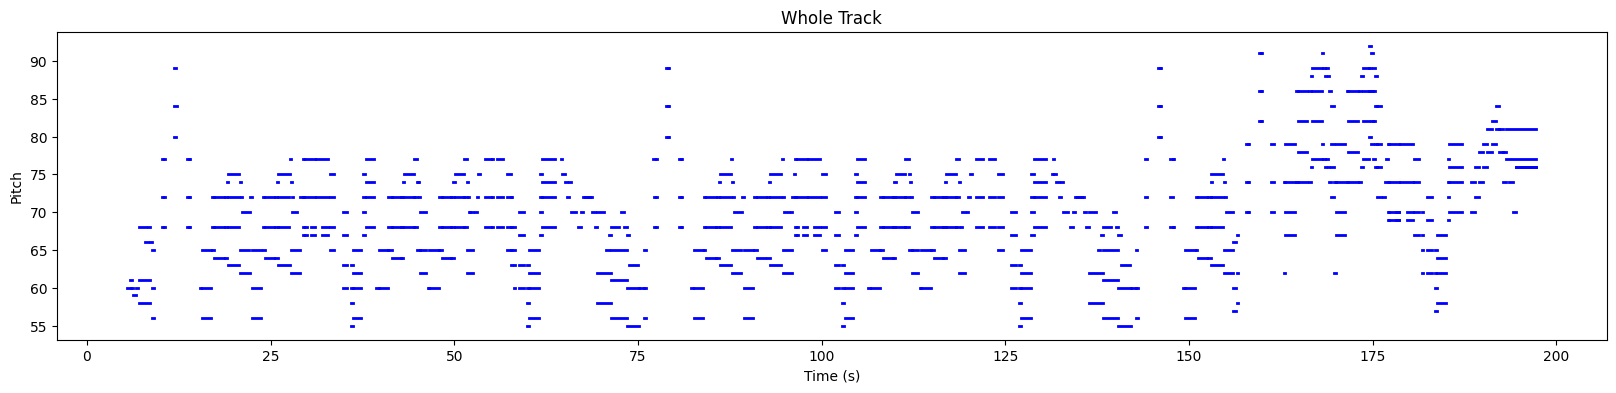

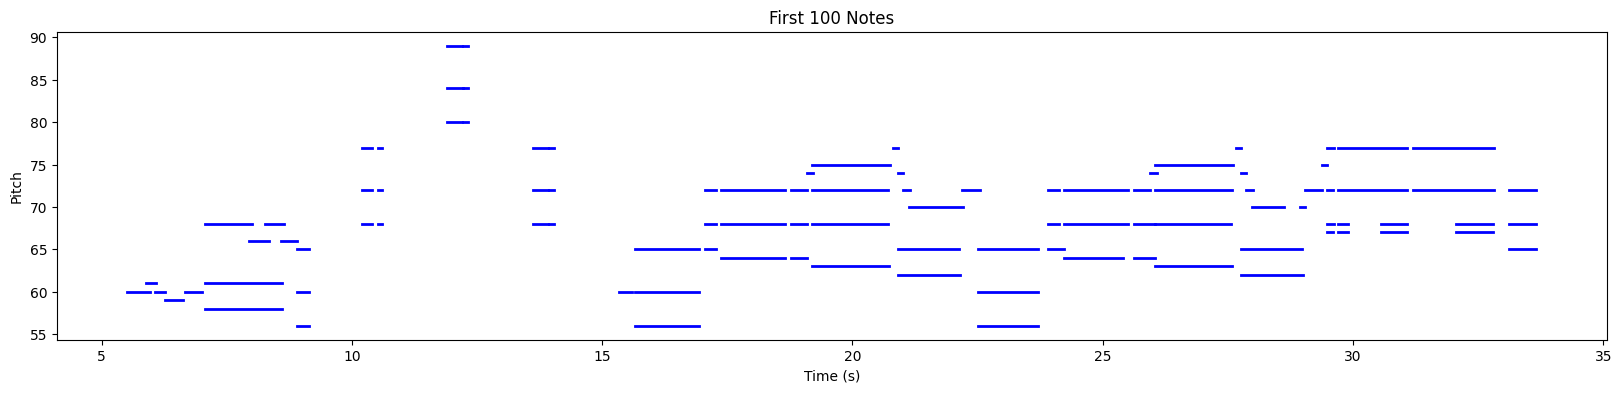

In [10]:
plot_piano_roll(raw_notes)
plot_piano_roll(raw_notes, 100)

In [11]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

print("No. of notes parsed:", len(all_notes))

key_order = ['pitch', 'step', 'duration']
train_notes = all_notes[['pitch', 'step', 'duration']].to_numpy()

notes_dataset = tf.data.Dataset.from_tensor_slices(train_notes)

# Print out Tensor shape, type and name
notes_dataset.element_spec

No. of notes parsed: 5674


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [12]:
def create_sequences(dataset: tf.data.Dataset, length: int, vocab_size: int=128) -> tf.data.Dataset:
    length += 1

    windows = dataset.window(length, shift=1, stride=1, drop_remainder=True)

    flatten = lambda x: x.batch(length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalise pitch only (dose not affect step and duration)
    def scale_pitch(x):
        x = x/[vocab_size, 1.0, 1.0]
        return x

    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key: labels_dense[i] for i, key in enumerate(key_order)}

        return (scale_pitch(inputs), labels)

    sequences = sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

    return sequences

length = 25
vocab_size = 128
sequence_dataset = create_sequences(notes_dataset, length, vocab_size)

In [13]:
batch_size = 64
buffer_size = len(notes) - length
train_dataset = (sequence_dataset
                    .shuffle(buffer_size)
                    .batch(batch_size, drop_remainder=True)
                    .cache()
                    .prefetch(tf.data.AUTOTUNE))

In [14]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [18]:
input_shape = (length, 3)
learning_rate = 0.005

inputs = layers.Input(input_shape)
x = layers.LSTM(500)(inputs)
outputs = {
    'pitch': layers.Dense(128, name='pitch')(x),
    'step': layers.Dense(1, name='step')(x),
    'duration': layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 500)                  1008000   ['input_2[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    501       ['lstm_1[0][0]']              
                                                                                                  
 pitch (Dense)               (None, 128)                  64128     ['lstm_1[0][0]']              
                                                                                            

In [19]:
callbacks = [callbacks.ModelCheckpoint(filepath='./training_checkpoints/ckpt_{epoch}', save_weights_only=True),
             callbacks.EarlyStopping(monitor='loss', patience=5, 
                                              verbose=1, restore_best_weights=True),]

AttributeError: 'list' object has no attribute 'ModelCheckpoint'

In [20]:
# Compiling and fitting the model

loss = {
    'pitch': losses.SparseCategoricalCrossentropy(from_logits=True),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure,
}

model.compile(loss = loss, 
              loss_weights = {'pitch': 0.9, 'step': 1.0, 'duration':1.0},
              optimizer=Adam(learning_rate=learning_rate))

epochs = 50

history = model.fit(train_dataset,
                    epochs=epochs, 
                    callbacks=callbacks)

Epoch 1/50


88/88 [==============================] - 5s 41ms/step - loss: 4.2745 - duration_loss: 0.5616 - pitch_loss: 3.5322 - step_loss: 0.5339
Epoch 2/50
88/88 [==============================] - 4s 44ms/step - loss: 3.4268 - duration_loss: 0.3461 - pitch_loss: 3.2838 - step_loss: 0.1253
Epoch 3/50
88/88 [==============================] - 4s 46ms/step - loss: 3.3258 - duration_loss: 0.2945 - pitch_loss: 3.1561 - step_loss: 0.1909
Epoch 4/50
88/88 [==============================] - 4s 46ms/step - loss: 3.2571 - duration_loss: 0.2768 - pitch_loss: 3.1706 - step_loss: 0.1268
Epoch 5/50
88/88 [==============================] - 4s 45ms/step - loss: 3.3191 - duration_loss: 0.2934 - pitch_loss: 3.0983 - step_loss: 0.2373
Epoch 6/50
88/88 [==============================] - 4s 46ms/step - loss: 3.1093 - duration_loss: 0.2510 - pitch_loss: 3.0317 - step_loss: 0.1297
Epoch 7/50
88/88 [==============================] - 4s 46ms/step - loss: 3.1448 - duration_loss: 0.2250 - pitch_loss: 3.1112 - step_loss: 0.1

In [21]:
def predict_next_note(notes: np.ndarray, model: tf.keras.Model, 
                      temperature: float = 1.0) -> int:
    inputs = tf.expand_dims(notes, 0)
    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

In [26]:
temperature = 1.25
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# Normalise pitch
input_notes = (
    sample_notes[:length] / np.array([vocab_size, 1, 1])
)

generated_notes = []
prev_start = 0

for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration + 0.5)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

generated_notes.head(10)

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


,pitch,step,duration,start,end
0,74,0.179265,0.723214,0.179265,0.402478
1,34,0.161845,0.586881,0.341110,0.427990
2,76,0.115139,0.583977,0.456248,0.540226
3,68,0.102875,0.585421,0.559124,0.644544
4,60,0.095673,0.585009,0.654797,0.739805
5,57,0.089981,0.579722,0.744778,0.824500
6,88,0.086478,0.576539,0.831256,0.907795
7,46,0.075094,0.612597,0.906350,1.018947
8,57,0.080531,0.570537,0.986881,1.057418
9,54,0.082099,0.584603,1.068980,1.153583


In [27]:
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str,
                  velocity: int = 100) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        
        note = pretty_midi.Note(velocity=velocity, pitch=int(note['pitch']),
                                start=start, end=end)
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [28]:
out_file = './out/output_1_adl.midi'
out_pm = notes_to_midi(generated_notes, out_file=out_file, instrument_name=instrument_name)   

In [29]:
import pygame

pygame.init()

pygame.mixer.music.load('./out/output_1_adl.midi')
pygame.mixer.music.play(fade_ms=5000)

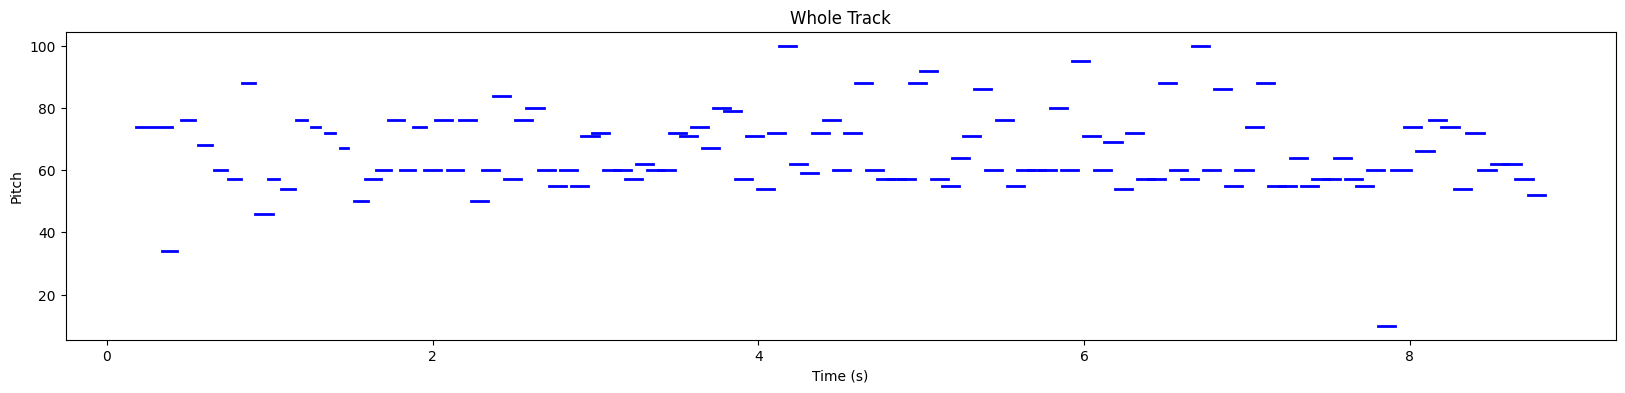

In [30]:
plot_piano_roll(generated_notes)